In [1]:
import torch
import os
from hmc_u1 import HMC_U1
from hmc_u1_ft import HMC_U1_FT
from nn_model_part import NNFieldTransformation
from utils import hmc_summary


In [2]:
# Parameters
lattice_size = 16
volume = lattice_size ** 2
beta = 5.5
n_thermalization_steps = 100
n_steps = 80
step_size = 0.1
n_iterations = 1024

# Initialize device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda'

# Set default type
torch.set_default_dtype(torch.float32)

# Set threading parameters
n_threads = 1
n_interop_threads = 1
torch.set_num_threads(n_threads)
torch.set_num_interop_threads(n_interop_threads)
os.environ["OMP_NUM_THREADS"] = str(n_threads)

### No Field Transformation

>>> No Field Transformation HMC Simulation: 


Thermalizing:   0%|          | 0/100 [00:00<?, ?it/s]

Running HMC: 100%|██████████| 1024/1024 [00:25<00:00, 40.27it/s]


>>> Simulation completed


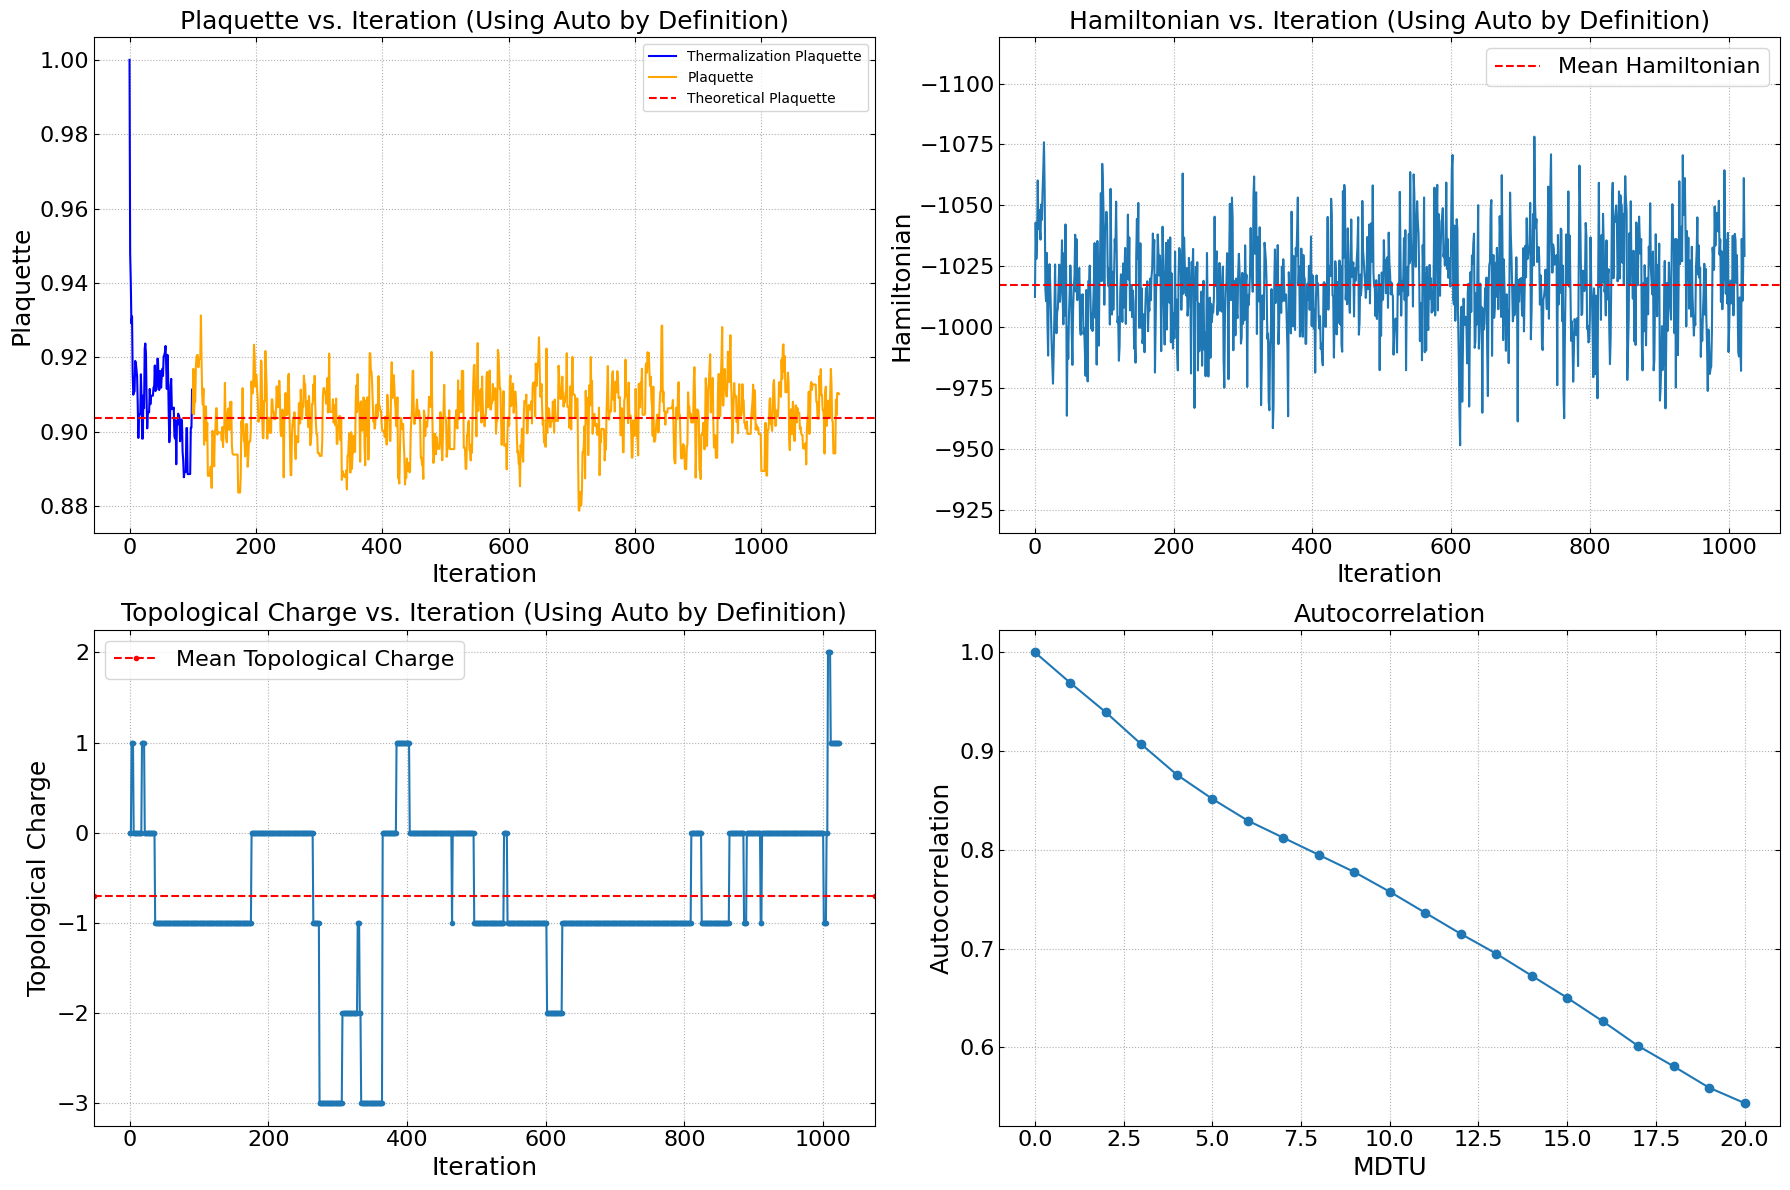

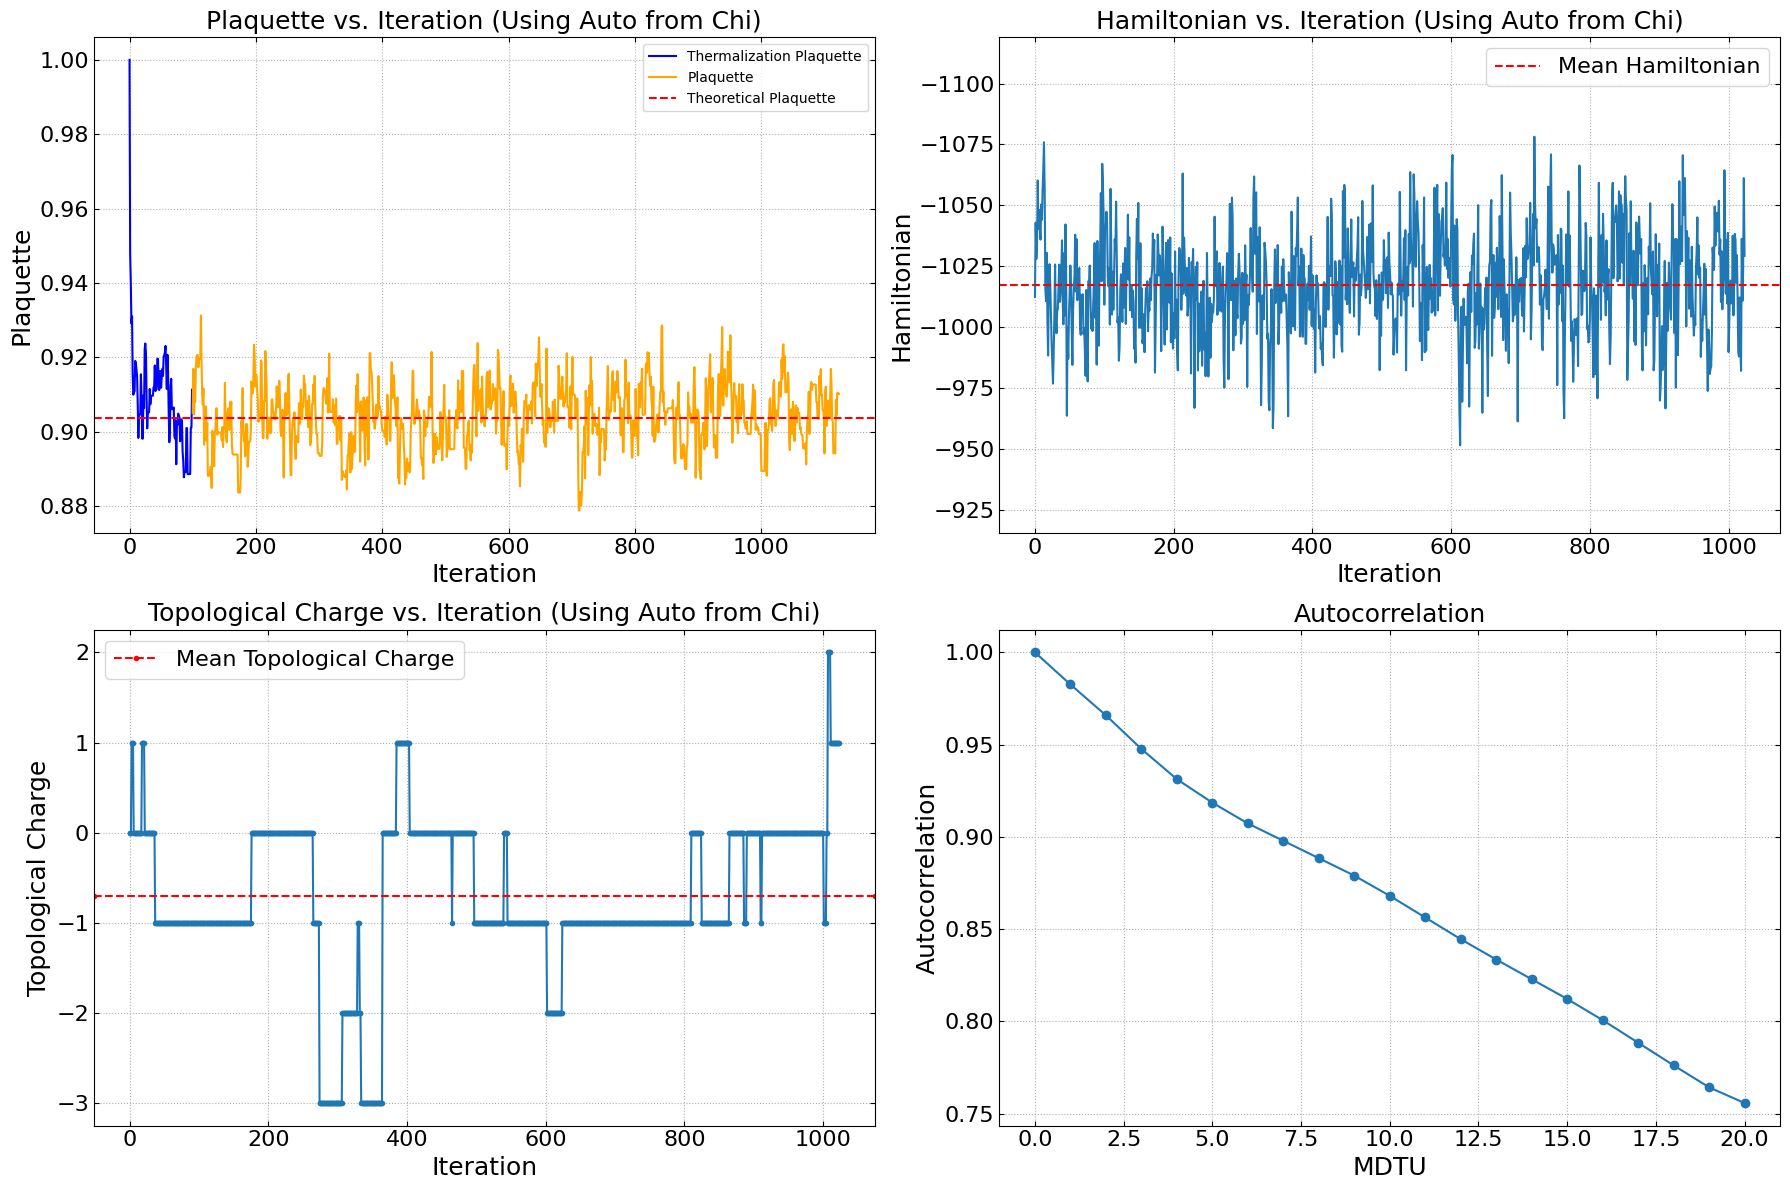

Thermalization acceptance rate: 0.7900
Acceptance rate: 0.7588


In [3]:
print(">>> No Field Transformation HMC Simulation: ")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

### Neural Network Field Transformation

>>> Neural Network Field Transformation HMC Simulation: 


Training Neural Network: 100%|██████████| 200/200 [00:07<00:00, 28.45it/s]


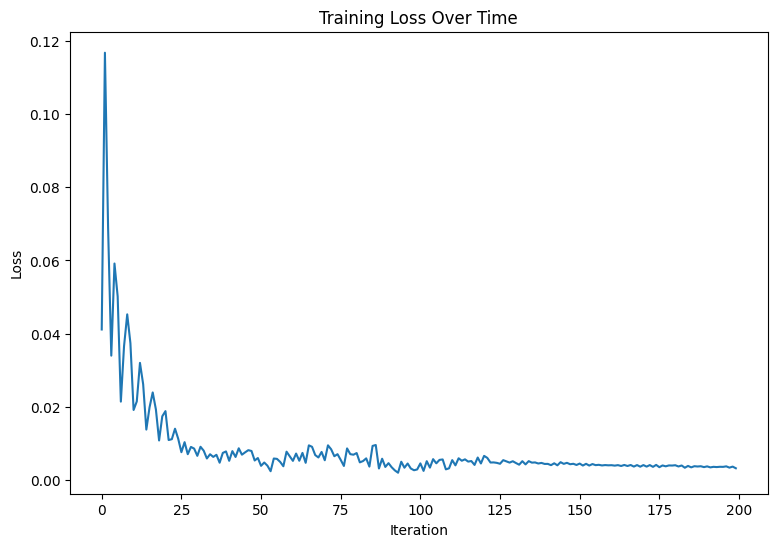


Neural Network Field Transformation Structure:
CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


Running HMC: 100%|██████████| 1024/1024 [16:04<00:00,  1.06it/s] 


>>> Simulation completed


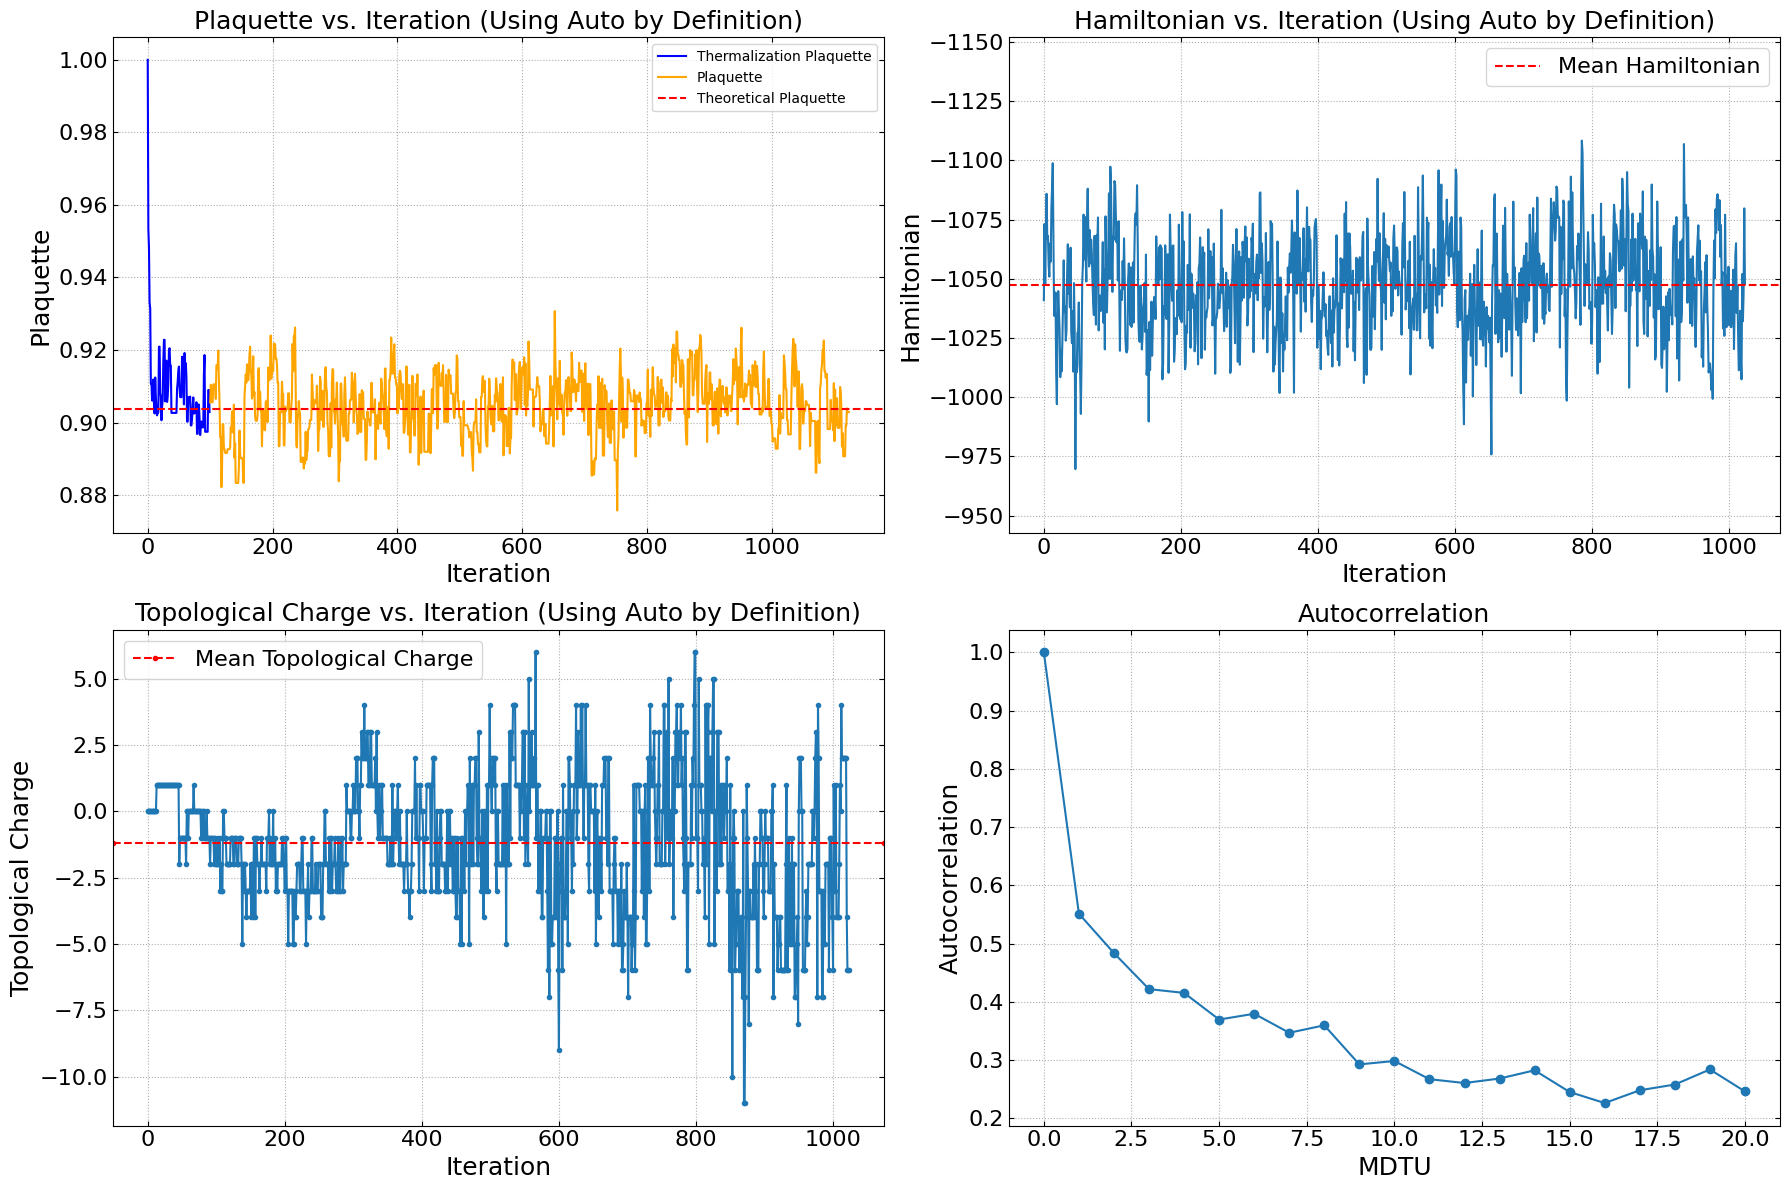

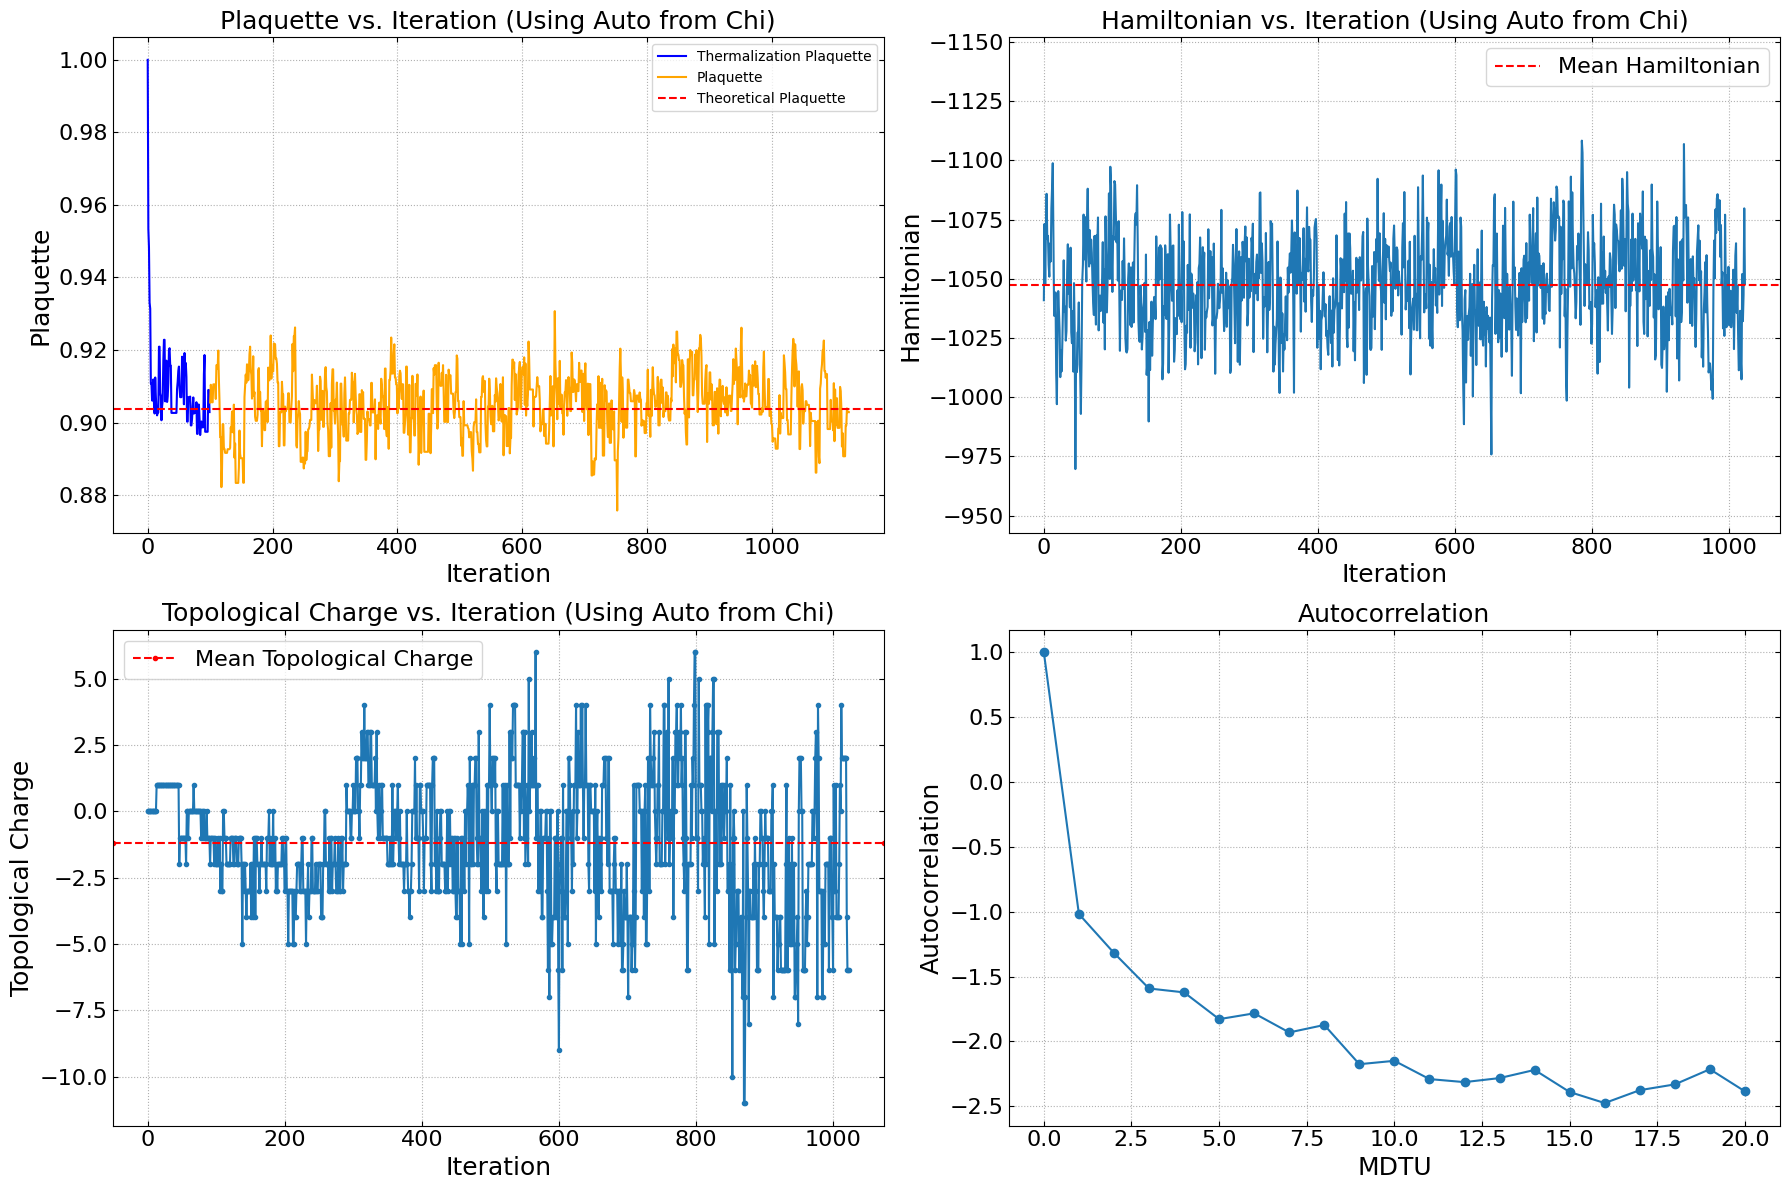

Thermalization acceptance rate: 0.6900
Acceptance rate: 0.7070


In [4]:
print(">>> Neural Network Field Transformation HMC Simulation: ")

# Train the neural network force
nn_transformation = NNFieldTransformation(lattice_size, model_type='CNN', epsilon=0.1, epsilon_decay=1, jacobian_interval=20, device=device)
nn_transformation.train(beta, n_iterations=200)

# Print the trained neural network structure and parameters
print("\nNeural Network Field Transformation Structure:")
print(nn_transformation.model)


# Initialize HMC
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=nn_transformation, jacobian_interval=64, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)